Geodesic distance transform
This notebook shows how Geodesic Discance Transform (GDT) using Fast Sweeping Method (FSM) can be implemented using Python. GDT can be thought of as a computation of shortest pathes on an image plane with a given cost function.

In [1]:
%load_ext Cython
import numpy as np
import scipy.ndimage as ndimage
import itertools as it
from skimage import io as skimio
import matplotlib.pyplot as mpplot
mpplot.rcParams['figure.figsize'] = (12,8)

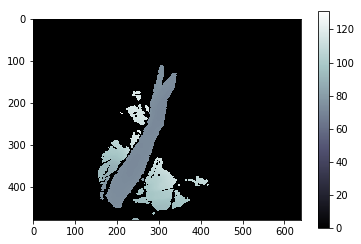

In [2]:
fig, ax = mpplot.subplots()
img = skimio.imread('image_D00000030.png').astype(float)
img /= 2000.
img[1. < img] = 0.
img *= 255.
#img[1e-3 > img] = 1
#img = 1 - img
#img = np.clip(img, 0, 1)
mpplot.imshow(img, cmap='bone')
mpplot.colorbar()
mpplot.show()

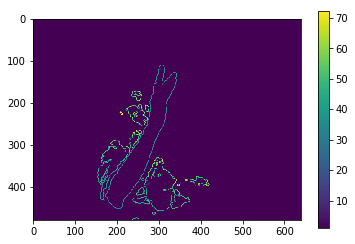

In [3]:
fig, ax = mpplot.subplots()
Cost = ndimage.gaussian_gradient_magnitude(img, 0.5)
#Cost = np.multiply(Cost, img)
#Cost = 1. + Cost*200.
Cost = 1. + Cost
mpplot.imshow(Cost)
mpplot.colorbar()
mpplot.show()

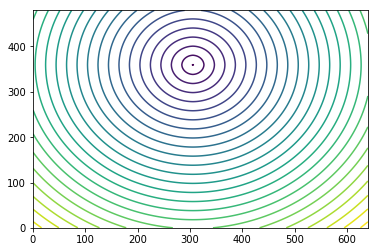

In [4]:
import skfmm
phi = np.ones_like(Cost) * np.max(Cost) * 100
gpi = np.where(1. < Cost)
phi[gpi] = Cost[gpi]
phi[120, 305] = -100.
d = skfmm.distance(phi, dx=1e-2)
mpplot.contour(d, 30, origin='image')
mpplot.show()

1.0


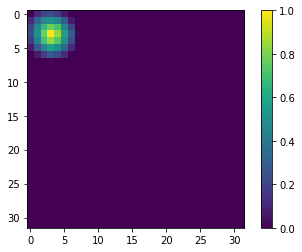

In [5]:
import skfmm
X, Y = np.meshgrid(np.linspace(-1,1,32), np.linspace(-1,1,32))
phi = (X+0.8)**2+(Y+0.8)**2 - 0.01
d = skfmm.distance(phi, dx=2.0/5)
d[1 < d] = 1
d = 1 - d
d /= np.max(d)
#mpplot.contour(d, 30)
mpplot.imshow(d)
mpplot.colorbar()
mpplot.show()

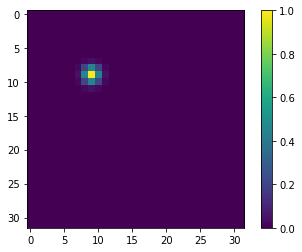

In [6]:
import scipy.ndimage
sp = np.zeros((32, 32))
sp[9, 9] = 1
sp = scipy.ndimage.gaussian_filter(sp, sigma=0.8)
sp /= np.max(sp)
mpplot.imshow(sp)
mpplot.colorbar()
mpplot.show()

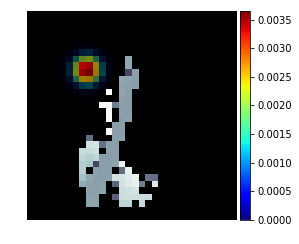

In [50]:
import scipy.ndimage
from cv2 import resize as cv2resize
from mpl_toolkits.axes_grid1 import make_axes_locatable
sp = np.zeros((128, 128))
sp[36, 36] = 1
sp = scipy.ndimage.gaussian_filter(sp, sigma=6.4)
sp = cv2resize(sp, (32, 32))
img32 = cv2resize(img, (32, 32))
fig = mpplot.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.axis('off')
#fig.subplots_adjust(0, 0, 1, 1)
ax.imshow(img32, cmap='bone', interpolation='nearest')

def transparent_cmap(cmap, N=255):
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.99, N+4)
    return mycmap

#ax.imshow(sp, cmap=transparent_cmap(mpplot.cm.jet))
img_sp = ax.imshow(sp, cmap='jet', alpha=0.9)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img_sp, cax=cax)
mpplot.show()

In [8]:
a = np.array([[0,1],[2,3]])
b = np.array([[4,5],[6,7]])
c = np.stack((a, b), axis=2)
print(a)
print(c)

[[0 1]
 [2 3]]
[[[0 4]
  [1 5]]

 [[2 6]
  [3 7]]]


In [9]:
%%cython
from libc.math cimport sqrt

def sweep(double[:,:] A, double[:,:] Cost):
    cdef int i, j
    cdef float t0, t1, t2, C, max_diff = 0.0
    for i in xrange(1, A.shape[0]):
        for j in xrange(1, A.shape[1]):
            t1, t2 = A[i, j-1], A[i-1, j]
            C = Cost[i, j]
            if abs(t1-t2) > C:
                t0 = min(t1, t2) + C  # handle degenerate case
            else:    
                t0 = 0.5*(t1 + t2 + sqrt(2*C**2 - (t1-t2)**2))
            max_diff = max(max_diff, A[i, j] - t0)
            A[i, j] = min(A[i, j], t0)
    return max_diff

In [10]:
def GDT(A, C):
    A = A.copy()
    sweeps = [A, A[:,::-1], A[::-1], A[::-1,::-1]]
    costs = [C, C[:,::-1], C[::-1], C[::-1,::-1]]
    for i, (a, c) in enumerate(it.cycle(zip(sweeps, costs))):
        print(i)
        if sweep(a, c) < 1.0 or i >= 40:
            break
    return A

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


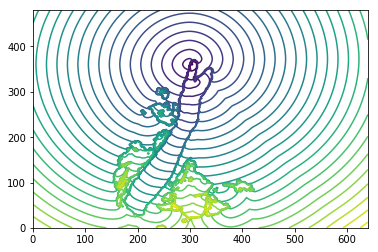

In [11]:
A = np.zeros_like(Cost) # create distance accumulation array
A[:] = 1e5           # fill it with large values to mark
                     # cells with unknown distance
A[120, 300] = 0.      # set the source

A = GDT(A, Cost)
mpplot.contour(A, 30, origin='image')
mpplot.show()